# Fidelity Prediction Of JanusQ-CT on Quantum Simualtor

**Author:** Congliang Lang \& Siwei Tan  

**Date:** 7/4/2024

Based on "[QuCT: A Framework for Analyzing Quantum Circuit by Extracting Contextual and Topological Features (MICRO 2023][1]"

[1]: https://scholar.google.com/scholar_url?url=https://dl.acm.org/doi/abs/10.1145/3613424.3614274%3Fcasa_token%3DffjIB1hQ4ZwAAAAA:8MajDLrDOC74WoeMf7r7AoQ-koxCa4E1TNqQg3GSDz03xUX6XdE3toNTM-YdM_e4rKEusMceJ6BGJg&hl=zh-CN&sa=T&oi=gsb&ct=res&cd=0&d=11146218754516883150&ei=42YSZpPlFL6s6rQPtt6x6Ac&scisig=AFWwaeYaiu2hyx8HUJ_7Buf9Mwom

JanusQ enables an accurate fidelity prediction by considering the gate-dependent error (e.g. crosstalk and pulse distortion). Specifially, JanusQ uses a vectorization model to extract the topological and contextual information of circuits and intergate this information into the prediction. 

In this notebook, we introduce the fidelity prediction on the simulator. We also introduce the prediction on ther real world quantum device in the "[2-3.fidelity_prediction_realqc.ipynb][2]"

[2]: https://github.com/JanusQ/JanusQ/blob/main/janusq/examples/fidelity_prediction_18_qubit_realqc.ipynb


In [ ]:
%matplotlib inline
import sys
sys.path.append('..')
import os
os.chdir("..")
import logging
logging.basicConfig(level=logging.INFO)
from janusq.analysis.fidelity_prediction import FidelityModel
from janusq.baselines.fidelity_prediction.rb_prediction import RBModel
from janusq.simulator.gate_error_model import GateErrorModel

from janusq.analysis.vectorization import RandomwalkModel

from janusq.data_objects.random_circuit import random_circuits, random_circuit
from janusq.data_objects.backend import Backend, LinearBackend, GridBackend, FullyConnectedBackend

from janusq.simulator.noisy_simulator import NoisySimulator
import random

from janusq.tools.ray_func import map
import numpy as np
import ray

ray.init(log_to_driver=False)

## Constructing a vectorization model

JanusQ provides a simualtor that can model the gate-dependent error. To intialize this simulator, we first define a backend and construct a vectorization model.

In [2]:
# define a 10-qubit backend
n_qubits = 8
n_steps = 1
n_walks = 20
backend = LinearBackend(n_qubits, 1)

In [3]:
circuits = random_circuits(backend, n_circuits=300, n_gate_list=[30, 50, 100], two_qubit_prob_list=[.4], reverse=True)

vec_model = RandomwalkModel(n_steps = n_steps, n_walks = n_walks, backend = backend)
vec_model.train(circuits, multi_process=False, remove_redundancy = False)



INFO:root:start random walk for 300 circuits
100%|██████████| 300/300 [00:02<00:00, 142.56it/s]
INFO:root:count path
INFO:root:device size after random walk = 15
INFO:root:0's path table size = 11
INFO:root:1's path table size = 16
INFO:root:2's path table size = 19
INFO:root:3's path table size = 19
INFO:root:4's path table size = 19
INFO:root:5's path table size = 19
INFO:root:6's path table size = 16
INFO:root:7's path table size = 11
INFO:root:(0, 1)'s path table size = 13
INFO:root:(1, 2)'s path table size = 18
INFO:root:(3, 4)'s path table size = 21
INFO:root:(2, 3)'s path table size = 21
INFO:root:(6, 7)'s path table size = 13
INFO:root:(4, 5)'s path table size = 21
INFO:root:(5, 6)'s path table size = 18


## Defining a simulator

The high gate-dependent errors in the simulator are represented by 1-step paths. The interaction is modeled by applying an RX operator with a random angle $[-\pi/20, \pi/20]$. In other words, the two gates of a 1-step path will be added with the RX operator if this path is injected with a noise.

In [4]:
# select 20 paths to represents sigificant interactions
all_paths = vec_model.all_paths()
high_error_paths = random.choices(all_paths, k = 20)

# inject these paths into the error model of the simulator
error_model = GateErrorModel.random_model(backend=backend, high_error_paths=high_error_paths)
error_model.vec_model = vec_model

# construct the simualtor
simulator = NoisySimulator(backend=backend, gate_error_model = error_model)

We can use this simualtor to collect ground-truth fidelities.

In [5]:
ground_truth_fidelities = map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], circuits, show_progress=True, multi_process=True)

100%|██████████| 30/30 [00:22<00:00,  1.32it/s]


## Fidelity prediction

JanusQ-CT formulates the error $E$ of each gate as the dot-product between its vector $v_i$ and a weight vector $W$. The fidelity of the circuit $F_{circuit}$ is represented as the product of the gate fidelities (1 - gate error):
\begin{equation}
\begin{aligned}
    & E(v_i) = W^\top v_i, \\
    & F_{circuit} = \prod_{g_i \in G} (1- E(v_i)) \prod_{q \in Q} MF_{q}.
\end{aligned}
\end{equation}
The weight vector $W$ is trained by the stochastic gradient descent algorithm based on a fidelity dataset, consisting of the circuits and their ground-truth fidelities on the quantum devices.

In [6]:
# intialize the model and train weight vector W
fidelity_model = FidelityModel(vec_model)
fidelity_model.train((circuits, ground_truth_fidelities), multi_process = True)

INFO:root:len(train dataset) = 240, len(validation dataset) = 60
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
240it [00:00, 449992.38it/s]
100%|██████████| 8/8 [00:00<00:00, 83.91it/s]
60it [00:00, 262965.77it/s]
100%|██████████| 3/3 [00:00<00:00, 19.06it/s]
INFO:root:epoch: 0, 	 epoch loss = 869.0015258789062, 	 validation loss = 8.016942977905273
INFO:root:epoch: 100, 	 epoch loss = 134.72879028320312, 	 validation loss = 1.5623958110809326
INFO:root:epoch: 200, 	 epoch loss = 57.51264190673828, 	 validation loss = 0.6142600774765015
INFO:root:epoch: 300, 	 epoch loss = 48.59381103515625, 	 validation loss = 0.514838695526123
INFO:root:epoch: 400, 	 epoch loss = 45.2153739929

### Evaluate the Fidelity Prediction Model

JanusQ-CT is more accurate compared to previous method, such as the [random benchmarking][3]. We build a random benchmarking model to suggest that.

[3]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.77.012307

In [7]:
from janusq.baselines.fidelity_prediction.rb_prediction import RBModel
rb_model = RBModel(simulator, multi_process = True)

100%|██████████| 1/1 [12:33<00:00, 753.49s/it]


In [8]:
# generate fidelity dataset
benchmarking_circuits = random_circuits(backend, n_circuits=300, n_gate_list=[30, 50, 100], two_qubit_prob_list=[.4], reverse=True)
benchmarking_fidelities = np.array(map(lambda circuit: simulator.obtain_circuit_fidelity(circuit)[0], benchmarking_circuits, show_progress=True, multi_process=True))

rb_fidelities = np.array(map(lambda circuit: rb_model.predict_circuit_fidelity(circuit), benchmarking_circuits))
janusct_fidelities = np.array(map(lambda circuit: fidelity_model.predict_circuit_fidelity(circuit), benchmarking_circuits))


100%|██████████| 30/30 [00:22<00:00,  1.31it/s]


0.6915073803645004 0.1935723918154411
0.9650544770770523 0.11081972090151675


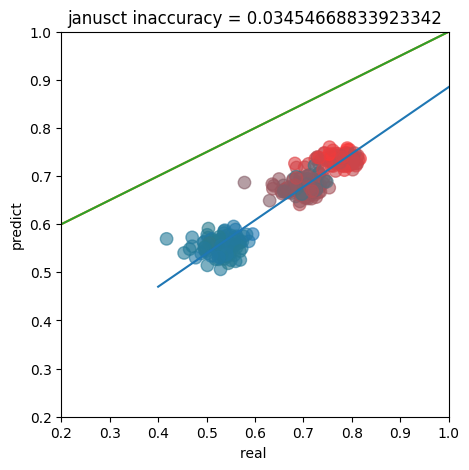

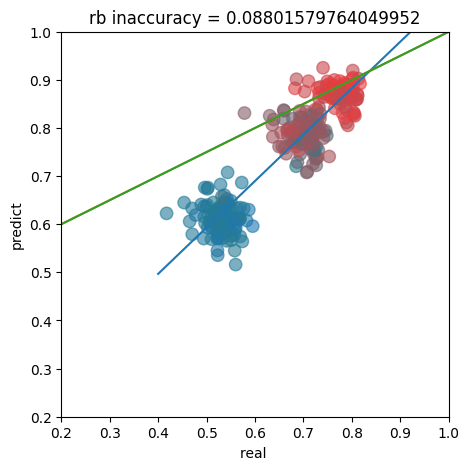

In [9]:

import matplotlib.pyplot as plt
from janusq.tools.plot import plot_scaater

durations = np.array([cir.duration for cir in benchmarking_circuits])

fig_quct, axes_quct = plot_scaater(benchmarking_fidelities, janusct_fidelities, durations, title = f"janusct inaccuracy = {np.abs(benchmarking_fidelities - janusct_fidelities).mean()}")
fig_rb, axes_rb = plot_scaater(benchmarking_fidelities, rb_fidelities, durations, title = f"rb inaccuracy = {np.abs(benchmarking_fidelities - rb_fidelities).mean()}")
